In [532]:
import numpy, scipy, pandas
import matplotlib.pyplot as plt

class Triangle:
    def __init__(self,a,b,c):

        # initialize the vertices
        self.a = numpy.array(a)
        self.b = numpy.array(b)
        self.c = numpy.array(c)
        
        # define the Jacobian and its inverse
        col1 = self.a - self.c
        col2 = self.b - self.c
        col3 = numpy.cross(col1,col2)
        self.Jac = numpy.array([col1,col2,col3])
        self.JacInv = numpy.linalg.inv(self.Jac)
        self.J = numpy.linalg.norm(col3)

        self.area = self.J/2
        
        # initialize the quadrature points
        self.qp = []
        self.n = 0
        
    # get map from reference to this triangle
    def refToPhys(self,point):
        return numpy.dot(self.Jac, numpy.array([point[0],point[1],0])) + self.c
    
    # plot the triangle
    def plotElement(self):
        from mpl_toolkits.mplot3d import Axes3D
        import matplotlib.pyplot as plt
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        ax.scatter(*self.a)
        ax.scatter(*self.b)
        ax.scatter(*self.c)
        #from mpl_toolkits.mplot3d.art3d import Poly3DCollection
        #poly3d = [1,0,0]
        #ax.add_collection3d(Poly3DCollection(poly3d, facecolors=['blue'], linewidths=1))
        plt.show()

    def setUniformQP(self,n):
        self.n = n
        refQP = [numpy.array([j+0.5,n+.5-i],float)/n for i in range(n+1) for j in range(i)]
        self.qp = [self.refToPhys(point) for point in refQP]
        return len(self.qp)
        
    def plotQP(self):
        from mpl_toolkits.mplot3d import Axes3D
        import matplotlib.pyplot as plt
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        [ax.scatter(*point) for point in self.qp]
        plt.show()
        
    def coordsDuffy(self,t):
        t1 = t[0]
        t2 = t[1]
        return numpy.array((1.-(t1+1.)/2.)*self.c + \
                           (t1+1.)/2. * (1.- (t2+1.)/2.)*self.a + \
                           (t1+1.)*(t2+1.)*self.b/4.)

In [542]:
# kernels

# weakly singular
def g(r,rp,k=1):
    R = numpy.linalg.norm(numpy.array(r)-numpy.array(rp))
    return numpy.exp(-1j*k*R)/(4*numpy.pi*R)

# strongly singular, coordinate-wise
def gradgx(r,rp,k=1):
    R = numpy.linalg.norm(numpy.array(r)-numpy.array(rp))
    (r[0]-rp[0]) * (-1j*numpy.exp(-1j*R)*R - numpy.exp(-1j*R))/numpy.power(R,3)
    return numpy.exp(-1j*k*R)/(4*numpy.pi*R)

def gradgy(r,rp,k=1):
    (r[1]-rp[1]) * (-1j*numpy.exp(-1j*R)*R - numpy.exp(-1j*R))/numpy.power(R,3)
    return numpy.exp(-1j*k*R)/(4*numpy.pi*R)

def gradgz(r,rp,k=1):
    (r[2]-rp[2]) * (-1j*numpy.exp(-1j*R)*R - numpy.exp(-1j*R))/numpy.power(R,3)
    return numpy.exp(-1j*k*R)/(4*numpy.pi*R)



In [534]:
# integrate g(r,r')*div(\Lambda_1) via uniform midpoint rule
def approxUniform(T,g,rp,n):
    T.setUniformQP(n)
    value = 0.0
    for point in T.qp:
        testA = point - T.a
        testB = point - T.b
        testA = testA/numpy.linalg.norm(testA)
        testB = testB/numpy.linalg.norm(testB)
        weight = 0.0
        if numpy.dot(testA,testB) == 1. or numpy.dot(testA,testB) == -1.:
            weight = 2.*n*n
        else:
            weight = n*n
        value += g(point,rp)*\
            (T.JacInv[1][1] + T.JacInv[2][2])*\
            T.J/weight
    return value

# Duffy transform approximation
def approxDuffy(T,g,rp,n):
    # determine quadrature rule for Duffy transform in the (t1,t2) coordinates
    value = 0.0
    tQP = [i for i in itertools.product(numpy.polynomial.legendre.leggauss(n)[0],\
                                            numpy.polynomial.legendre.leggauss(n)[0])]
    tW = [i for i in itertools.product(numpy.polynomial.legendre.leggauss(n)[1],\
                                            numpy.polynomial.legendre.leggauss(n)[1])]
    D1 = Triangle(rp,T.a,T.b)
    D2 = Triangle(rp,T.b,T.c)
    D3 = Triangle(rp,T.c,T.a)
    for D in [D1, D2, D3]:
        for i in range(len(tQP)):
            t1, t2 = tQP[i]
            tensorweight = tW[i][0]*tW[i][1]
            value += g(D.coordsDuffy([t1,t2]),rp)*\
                (T.JacInv[1][1] + T.JacInv[2][2])*\
                T.J*(t1+1.)/4.*D.area * tensorweight  
    return  value

In [ ]:
# test the Duffy transform
A = (1,1,5)
B = (0,2,5)
C = (0,1,5)
T = Triangle(A,B,C)

print '(-1,-1) got mapped to',T.coordsDuffy((-1,-1))
print '(-1, 0) got mapped to',T.coordsDuffy((-1,0))
print '(-1,+1) got mapped to',T.coordsDuffy((-1,1))

print '(+1,-1) got mapped to',T.coordsDuffy((1,-1))
print '(+1, 0) got mapped to',T.coordsDuffy((1,0))
print '(+1,+1) got mapped to',T.coordsDuffy((1,1))

print 'area is',T.area

(0, 1)

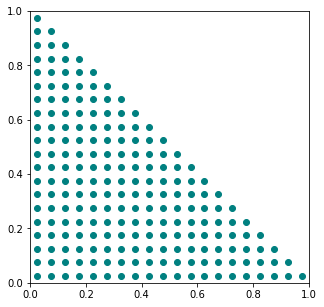

In [536]:
A = (1,0,0)
B = (0,1,0)
C = (0,0,0)
T = Triangle(A,B,C)
T.setUniformQP(20)
plt.figure(figsize=(5,5))
for point in T.qp:
    plt.scatter(point[0],point[1],color='teal')
plt.scatter(rp[0],rp[1],color='red')
plt.xlim(0,1)
plt.ylim(0,1)

In [557]:
A = (1,0,0)
B = (0,1,0)
C = (0,0,0)
rp = T.refToPhys((1./numpy.pi , 1/numpy.pi,0))
T = Triangle(A,B,C)
maxLevel = 200

results = [approxUniform(T,g,rp,int(i)) for i in numpy.linspace(1,maxLevel,20)]
data = pandas.DataFrame([numpy.real(results),numpy.imag(results)]).T
data.columns = ['real part', 'imag part']
data.index = [len([numpy.array([j+0.5,int(n)+.5-i],float)/int(n) for i in range(int(n)+1) for j in range(i)]) for n in numpy.linspace(1,maxLevel,20)]
data

,real part,imag part
1,0.599069,-0.157409
66,7.588425,-0.082522
231,0.376771,-0.079684
528,0.369546,-0.079757
903,0.379410,-0.078720
1431,0.369231,-0.078793
2016,0.369379,-0.078709
2775,0.392178,-0.078475
3570,0.371760,-0.078485
4560,0.371189,-0.078376


In [558]:
# check the result under the translation y+=1, z+=5
A = (1,1,5)
B = (0,2,5)
C = (0,1,5)
T = Triangle(A,B,C)
rp = T.refToPhys((1./numpy.pi , 1/numpy.pi))
maxLevel = 200

results = [approxUniform(T,g,rp,int(i)) for i in numpy.linspace(1,maxLevel,20)]
data = pandas.DataFrame([numpy.real(results),numpy.imag(results)]).T
data.columns = ['real part', 'imag part']
data.index = [len([numpy.array([j+0.5,int(n)+.5-i],float)/int(n) for i in range(int(n)+1) for j in range(i)]) for n in numpy.linspace(1,maxLevel,20)]
data

,real part,imag part
1,0.599069,-0.157409
66,7.590654,-0.083194
231,0.375235,-0.079320
528,0.369546,-0.079757
903,0.379205,-0.078675
1431,0.369074,-0.078687
2016,0.369159,-0.078594
2775,0.392093,-0.078460
3570,0.371601,-0.078462
4560,0.371193,-0.078400


In [553]:
# apply the Duffy transform for approximation
A = (1,0,0)
B = (0,1,0)
C = (0,0,0)
rp = T.refToPhys((1./numpy.pi , 1/numpy.pi,0))
T = Triangle(A,B,C)
maxLevel = 30

results = [approxDuffy(T,g,rp,int(i)) for i in numpy.linspace(2,maxLevel,10)]
data = pandas.DataFrame([numpy.real(results),numpy.imag(results)]).T
data.columns = ['real part', 'imag part']
data.index = [3*len(numpy.polynomial.legendre.leggauss(int(i))[0])**2 for i in numpy.linspace(1,maxLevel,10)]
data

,real part,imag part
3,0.371227,-0.078113
48,0.374818,-0.078113
147,0.373662,-0.078113
300,0.373014,-0.078113
507,0.372679,-0.078113
867,0.372488,-0.078113
1200,0.372371,-0.078113
1587,0.372294,-0.078113
2028,0.372241,-0.078113
2700,0.372193,-0.078113


In [572]:
%%timeit
n=20
approxUniform(T,g,rp,n)

100 loops, best of 3: 4.94 ms per loop


In [574]:
# that required this many quadrature points
n=20
print len([numpy.array([j+0.5,int(n)+.5-i],float)/int(n) for i in range(int(n)+1) for j in range(i)])

210


In [570]:
%%timeit
approxDuffy(T,g,rp,8)

100 loops, best of 3: 4.08 ms per loop


In [575]:
# this required this many quadrature points
n = 8
print 3*len(numpy.polynomial.legendre.leggauss(int(n))[0])**2

192


In [576]:
print approxUniform(T,g,rp,20)
print approxDuffy(T,g,rp,8)

(0.3861675541379834-0.07925642076492802j)
(0.373661592992128-0.07811285720668679j)
